In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
import numpy as np
import math
import shap

DATA PREPARATION

In [2]:
df = pd.read_csv('NFL PBP.csv')

Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
df.shape

(449371, 255)

In [4]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
df['game_id'] = df['game_id'].astype(str)
df['desc'] = df['desc'].astype(str)

# clean the data
for i in range(len(df['game_id'])):
    df.at[i, 'Year'] = df['game_id'][i][0:4] # will give the year of the game
    
for i in range(len(df['desc'])):
    if df['desc'][i].count('(') >= 1:
        # access the first letter before period and the word after (this will give full name; all in the description 'desc')
        number = df['desc'][i].find('.') 
        df.at[i, 'Player'] = df['desc'][i][number-1] + ' ' + df['desc'][i][number+1:].split(' ')[0]
    else:
        pass # do nothing

nfl_data = df[['game_seconds_remaining', 
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained',
               'yardline_100',
               'Player',
               'Year']].query(
                '(play_type == "pass") or (play_type == "run")').dropna()
nfl_data.head()

,game_seconds_remaining,ydstogo,posteam_score,defteam_score,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained,yardline_100,Player,Year
1,3593.0,10,0.0,0.0,1.0,0,pass,0,0,5.0,58.0,B Roethlisberger,2009
2,3556.0,5,0.0,0.0,2.0,0,run,0,0,-3.0,53.0,W Parker,2009
3,3515.0,8,0.0,0.0,3.0,1,pass,0,0,0.0,56.0,B Roethlisberger,2009
5,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009
6,3460.0,10,0.0,0.0,2.0,0,pass,0,0,4.0,98.0,K Collins,2009


In [6]:
nfl_data.shape

(318347, 13)

In [7]:
# create dictionary with all of the passing dataframes
years = list(range(2009,2019,1))

d = {}
for year in years:
    df = pd.read_csv(f'Pass {year}.csv')
    d[year] = df[['Player', 'Age', 'QBR', 'Y/G', 'Rate']]

In [8]:
d[2009].head()

,Player,Age,QBR,Y/G,Rate
0,Matt Schaub*\SchaMa00,28,73.8,298.1,98.6
1,Peyton Manning*+\MannPe00,33,81.3,281.3,99.9
2,Tom Brady*\BradTo00,32,73.2,274.9,96.2
3,Jay Cutler\CutlJa00,26,50.3,229.1,76.8
4,Tony Romo*\RomoTo00,29,64.5,280.2,97.6


In [9]:
def pass_data_cleaning(dic, lis):
    for year in lis:
        for i in range(len(dic[year]['Player'])):
            # if there's a *, grab the name before that *
            if dic[year]['Player'][i].count('*') >= 1:
                number = dic[year]['Player'][i].find('*')
                dic[year].at[i, 'Player'] = dic[year]['Player'][i][:number]
            # if there's a \, grab the name before that
            else:
                number = dic[year]['Player'][i].find('\\')
                dic[year].at[i, 'Player'] = dic[year]['Player'][i][:number]

        # make it so that the name matches the main dataframe, with just one letter for the first name
        for k in range(len(dic[year]['Player'])):
            dic[year].at[k, 'Player'] = list(dic[year]['Player'][k].split(' ')[0])[0] + ' ' + dic[year]['Player'][k].split(' ')[1]
            
        dic[year]['Year'] = year
            
    return dic

In [10]:
# pass the dictionary we created two cells above into the cleaning function
cleaned_dict = pass_data_cleaning(d, years)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
cleaned_dict[2009].head()

,Player,Age,QBR,Y/G,Rate,Year
0,M Schaub,28,73.8,298.1,98.6,2009
1,P Manning,33,81.3,281.3,99.9,2009
2,T Brady,32,73.2,274.9,96.2,2009
3,J Cutler,26,50.3,229.1,76.8,2009
4,T Romo,29,64.5,280.2,97.6,2009


In [12]:
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver

In [13]:
def rush_data_forming_and_cleaning(lis):
    d_2 = {}
    for year in lis:
        driver = webdriver.Firefox('./')
        driver.get(f'https://www.footballdb.com/statistics/nfl/player-stats/rushing/{year}/regular-season')

        source = driver.page_source
        soup = BeautifulSoup(source)

        table = soup.find('table', {'class':'statistics scrollable'})

        # gather the tags that containt the name of the running backs
        data1 = table.find_all('span', {'class':'hidden-xs'})

        # create a list of running backs; append what is inside of the 'a' tag
        running_backs = []
        for data in data1:
            name = (data.find('a'))
            running_backs.append(name.text)

        # gather the tags that contain the avg yards and yards per game of the running backs
        # create respective lists for those datapoints
        data2 = table.find_all('td')
        average_yds = data2[5::10]
        for i in range(len(average_yds)):
            average_yds[i] = average_yds[i].text
        average_yds = [float(i) for i in average_yds]

        ypg = data2[6::10]
        for i in range(len(ypg)):
            ypg[i] = ypg[i].text
        ypg = [float(i) for i in ypg]

        # form the running back dataframe for these lists
        RB_df = pd.DataFrame(
            {'Player': running_backs,
             'AVG': average_yds,
             'YPG': ypg,
             'Year': year
            })

        for k in range(len(RB_df['Player'])):
            RB_df.at[k, 'Player'] = RB_df['Player'][k].split(' ')[0][0] + ' ' + RB_df['Player'][k].split(' ')[1]
            
        d_2[year] = RB_df
        
    return d_2

In [14]:
d_2 = rush_data_forming_and_cleaning(years)

In [15]:
d_2[2009].head()

,Player,AVG,YPG,Year
0,C Johnson,5.60,125.4,2009
1,S Jackson,4.37,94.4,2009
2,T Jones,4.24,87.6,2009
3,M Jones-Drew,4.46,86.9,2009
4,A Peterson,4.40,86.4,2009


In [16]:
# form the quarterback and running back dataframes into list of dataframes
qb_list = [d[i] for i in years]
rb_list = [d_2[i] for i in years]

In [17]:
# concatenate the lists into separate dataframes
qb_df = pd.concat(qb_list)
rb_df = pd.concat(rb_list)

In [18]:
qb_df['Year'] = qb_df['Year'].astype(str)
rb_df['Year'] = rb_df['Year'].astype(str)

In [19]:
nfl_data = nfl_data.merge(qb_df, on=['Player', 'Year'], how='left').merge(rb_df, on=['Player', 'Year'], how='left')

nfl_data.head()

,game_seconds_remaining,ydstogo,posteam_score,defteam_score,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained,yardline_100,Player,Year,Age,QBR,Y/G,Rate,AVG,YPG
0,3593.0,10,0.0,0.0,1.0,0,pass,0,0,5.0,58.0,B Roethlisberger,2009,27.0,69.0,288.5,100.5,2.05,5.5
1,3556.0,5,0.0,0.0,2.0,0,run,0,0,-3.0,53.0,W Parker,2009,NaN,NaN,NaN,NaN,3.97,27.8
2,3515.0,8,0.0,0.0,3.0,1,pass,0,0,0.0,56.0,B Roethlisberger,2009,27.0,69.0,288.5,100.5,2.05,5.5
3,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009,24.0,0.1,0.0,39.6,5.60,125.4
4,3496.0,10,0.0,0.0,1.0,0,run,0,0,0.0,98.0,C Johnson,2009,24.0,0.1,0.0,39.6,10.43,5.2


PREDICTING "YARDS_GAINED" GIVEN:
- game_seconds_remaining (from 3600 downwards)
- ydstogo (until a first down)
- down (the number, 1 to 4)
- shotgun (binary, yes or no)
- play_type (run or pass)
- qb_kneel or qb_spike (binary, yes or no)
- yardline_100 (where you are on the field)
- posteam_score and defteam_score (possessing and defensive)
- rushing average yards per game and per carry (FOR RUSHING ONLY)
- quarterback age, yards/game, QBR, and rating (FOR PASSING ONLY)

In [20]:
nfl_pass_data = nfl_data[[
               'game_seconds_remaining',
               'yardline_100',         
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'Age',
               'QBR',
               'Y/G',
               'Rate',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained']].query('(play_type == "pass")').dropna()
nfl_pass_data.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
0,3593.0,58.0,10,0.0,0.0,27.0,69.0,288.5,100.5,1.0,0,pass,0,0,5.0
2,3515.0,56.0,8,0.0,0.0,27.0,69.0,288.5,100.5,3.0,1,pass,0,0,0.0
6,3460.0,98.0,10,0.0,0.0,37.0,41.1,175.0,65.5,2.0,0,pass,0,0,4.0
10,3384.0,43.0,10,0.0,0.0,27.0,69.0,288.5,100.5,1.0,0,pass,0,0,3.0
11,3348.0,40.0,7,0.0,0.0,27.0,69.0,288.5,100.5,2.0,0,pass,0,0,10.0


In [21]:
nfl_rush_data = nfl_data[[
               'game_seconds_remaining', 
               'yardline_100',
               'ydstogo',
               'posteam_score',
               'defteam_score',
               'AVG',
               'YPG',
               'down',
               'shotgun',
               'play_type',
               'qb_kneel',
               'qb_spike',
               'yards_gained']].query('(play_type == "run")').dropna()

nfl_rush_data.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
1,3556.0,53.0,5,0.0,0.0,3.97,27.8,2.0,0,run,0,0,-3.0
3,3496.0,98.0,10,0.0,0.0,5.60,125.4,1.0,0,run,0,0,0.0
4,3496.0,98.0,10,0.0,0.0,10.43,5.2,1.0,0,run,0,0,0.0
5,3496.0,98.0,10,0.0,0.0,10.67,2.0,1.0,0,run,0,0,0.0
7,3431.0,94.0,6,0.0,0.0,5.60,125.4,3.0,1,run,0,0,-2.0


In [22]:
# generate a seed; make results reproducable
np.random.seed(896)

NFL_pass = shuffle(nfl_pass_data)
NFL_pass.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,pass,0,0,4.0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,pass,0,0,0.0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,pass,0,0,12.0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,pass,0,0,0.0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,pass,0,0,7.0


In [23]:
# generate a seed; make results reproducable
np.random.seed(896)

NFL_rush = shuffle(nfl_rush_data)
NFL_rush.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,play_type,qb_kneel,qb_spike,yards_gained
176362,352.0,50.0,7,41.0,10.0,3.92,20.8,2.0,0,run,0,0,-1.0
106976,2852.0,70.0,10,0.0,7.0,3.80,43.7,1.0,0,run,0,0,5.0
268634,2479.0,85.0,5,17.0,0.0,4.43,47.9,2.0,1,run,0,0,0.0
6567,505.0,73.0,10,20.0,19.0,4.44,61.6,1.0,0,run,0,0,0.0
183987,2802.0,80.0,10,10.0,10.0,3.92,20.8,1.0,1,run,0,0,2.0


PASS DATA

In [24]:
# feature, or input, dataframe
NFL_pass_x  = NFL_pass.drop('yards_gained', axis=1)
NFL_pass_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,play_type,qb_kneel,qb_spike
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,pass,0,0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,pass,0,0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,pass,0,0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,pass,0,0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,pass,0,0


In [25]:
NFL_pass_x = NFL_pass_x.drop(['play_type'], axis=1)
NFL_pass_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,Age,QBR,Y/G,Rate,down,shotgun,qb_kneel,qb_spike
174565,2278.0,70.0,13,14.0,7.0,33.0,62.5,275.6,92.1,2.0,1,0,0
56744,279.0,77.0,7,36.0,26.0,23.0,47.0,219.5,76.5,3.0,1,0,0
277993,377.0,16.0,5,10.0,27.0,29.0,65.3,277.9,99.3,2.0,1,0,0
317709,3004.0,95.0,10,0.0,0.0,21.0,26.6,162.7,66.7,1.0,0,0,0
328511,1831.0,37.0,6,0.0,20.0,23.0,56.2,284.6,90.8,2.0,1,0,0


In [26]:
NFL_pass_x = NFL_pass_x.values
NFL_pass_x

array([[2.278e+03, 7.000e+01, 1.300e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.790e+02, 7.700e+01, 7.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.770e+02, 1.600e+01, 5.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.310e+02, 8.800e+01, 1.000e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.881e+03, 3.700e+01, 1.000e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.203e+03, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [27]:
# label, or output, dataframe
NFL_pass_y = NFL_pass['yards_gained'].values
NFL_pass_y

array([  4.,   0.,  12., ...,   0.,   9., -11.])

In [28]:
#split the data
valid_split = 0.2
test_split = 0.1

In [29]:
# create the splits in the dataframe
v_split = int(NFL_pass.shape[0]*(1-valid_split-test_split))
t_split = int(NFL_pass.shape[0]*(1-test_split))

# assign training, validation, and test data
X_train, Y_train  = NFL_pass_x[:v_split], NFL_pass_y[:v_split]
X_valid, Y_valid  = NFL_pass_x[v_split:t_split], NFL_pass_y[v_split:t_split]
X_test , Y_test   = NFL_pass_x[t_split:], NFL_pass_y[t_split:]

In [30]:
#standardize the data
scaler = preprocessing.StandardScaler().fit(X_train[:,0:9]) # mean and variance calculated on specified columns of X_train
X_train[:,0:9] = scaler.transform(X_train[:,0:9])
X_valid[:,0:9] = scaler.transform(X_valid[:,0:9])
X_test[:,0:9]  = scaler.transform(X_test[:,0:9])  

In [31]:
# check that the proper data was standardized
X_train[0]

array([ 0.55456831,  0.70556714,  1.02419449,  0.50622118, -0.51845532,
        0.9294753 ,  0.48688152,  0.77827633,  0.34886001,  2.        ,
        1.        ,  0.        ,  0.        ])

In [32]:
# import packages for the model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

BASIC MODEL, PASSING

In [33]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_pass_x.shape[1],), 
                activation='tanh'))
model.add(Dense(1, 
                activation='linear'))

In [34]:
model.compile(loss='mean_squared_error', 
              optimizer=Adam(learning_rate=0.01))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

In [37]:
model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
841/841 [==============================] - 1s 1ms/step - loss: 101.5875 - val_loss: 101.7691
Epoch 2/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.3831 - val_loss: 101.6663
Epoch 3/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.3080 - val_loss: 101.8234
Epoch 4/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.2641 - val_loss: 101.9140
Epoch 5/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.2792 - val_loss: 101.5946
Epoch 6/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.2354 - val_loss: 101.7503
Epoch 7/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.2121 - val_loss: 101.6293
Epoch 8/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.2398 - val_loss: 101.6483
Epoch 9/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.1840 - val_loss: 101.6884
Epoch 10/1000
841/841 [=======================

In [38]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 700us/step - loss: 100.9645


100.96446228027344

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

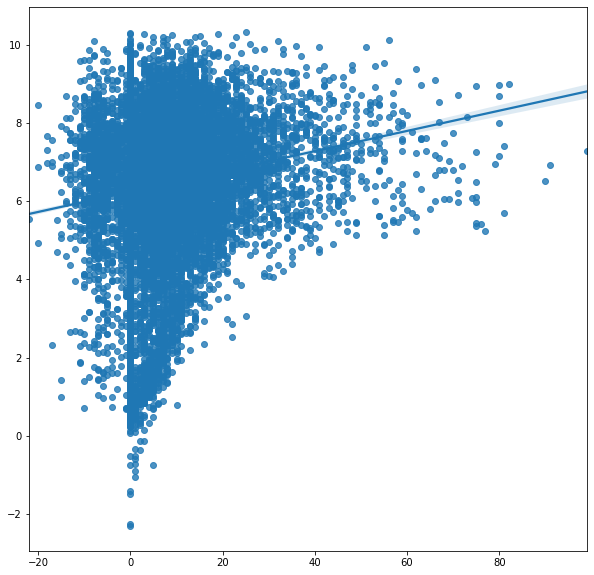

In [40]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

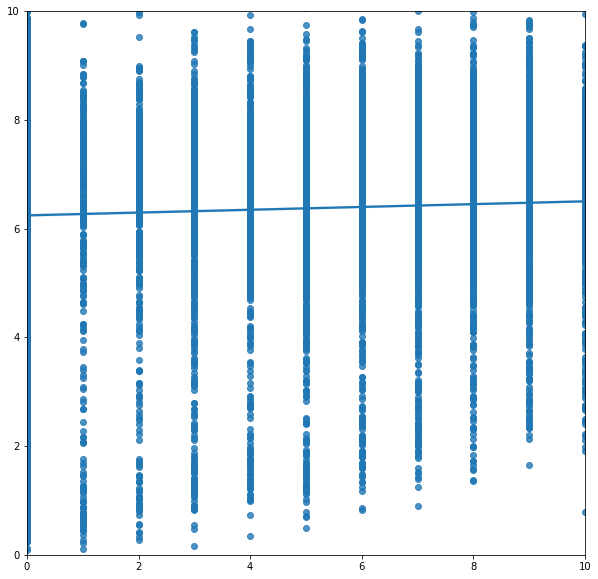

In [41]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

COMPLEX FULLY CONNECTED, PASSING

In [42]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_pass_x.shape[1],), 
                activation='tanh'))
model.add(Dense(20,  
                activation='tanh'))
model.add(Dense(20, 
                activation='tanh'))
model.add(Dropout(0.2))
    
model.add(Dense(1, 
                activation='linear'))



model.compile(loss='mean_squared_error', 
              optimizer=Adam(learning_rate=0.01))

es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
841/841 [==============================] - 2s 1ms/step - loss: 101.6456 - val_loss: 102.2407
Epoch 2/1000
841/841 [==============================] - 1s 1ms/step - loss: 101.1100 - val_loss: 101.8504
Epoch 3/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.8621 - val_loss: 101.9302
Epoch 4/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.8112 - val_loss: 101.9304
Epoch 5/1000
841/841 [==============================] - 1s 2ms/step - loss: 100.7154 - val_loss: 102.0280
Epoch 6/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.6620 - val_loss: 101.9340
Epoch 7/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.6312 - val_loss: 101.8995
Epoch 8/1000
841/841 [==============================] - 1s 1ms/step - loss: 100.5332 - val_loss: 101.7785
Epoch 9/1000
841/841 [==============================] - 1s 2ms/step - loss: 100.5174 - val_loss: 101.7950
Epoch 10/1000
841/841 [=======================

In [43]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 680us/step - loss: 100.9701


100.97013092041016

<AxesSubplot:>

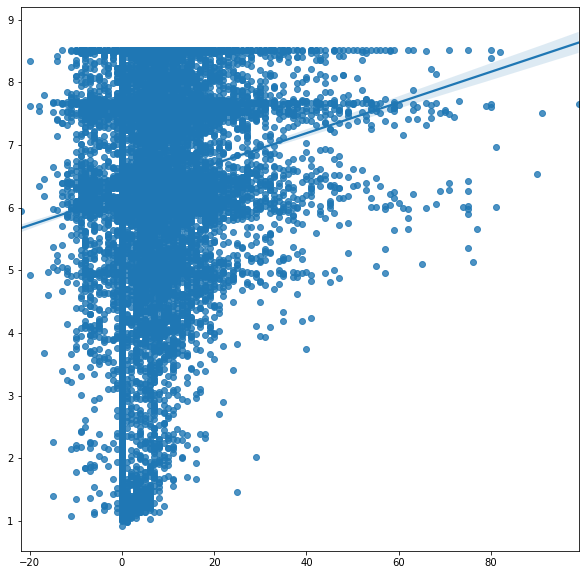

In [44]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

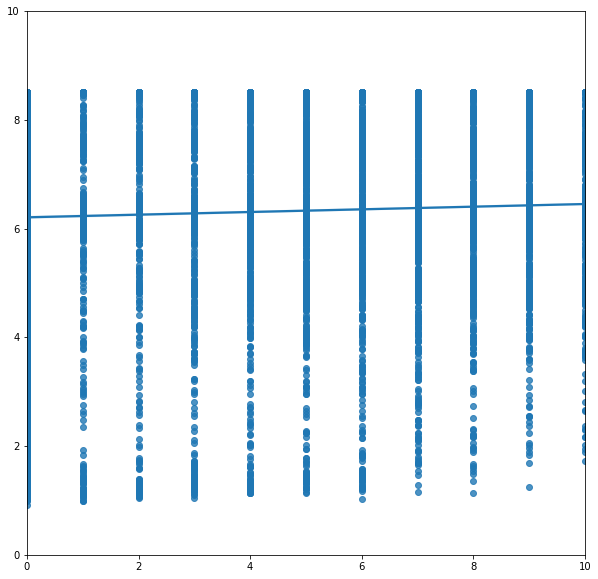

In [45]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

BASIC MODEL, RESIDUAL CONNECTION

In [46]:
# Model
inp = Input(shape=(X_train.shape[1],))

x = inp
x = Dense(10, activation='sigmoid')(x)
x = Dense(5, activation='sigmoid')(x)

res = Dense(5, activation='sigmoid')(inp)

x = add([x,res])

out = Dense(1, activation='linear')(x)

In [47]:
model = Model(inputs = inp, outputs=out)

In [48]:
es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.1))
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
841/841 [==============================] - 1s 1ms/step - loss: 101.0676 - val_loss: 103.1199
Epoch 2/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.8162 - val_loss: 103.0072
Epoch 3/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7543 - val_loss: 102.6014
Epoch 4/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7728 - val_loss: 102.5892
Epoch 5/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6626 - val_loss: 102.0912
Epoch 6/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7220 - val_loss: 102.1037
Epoch 7/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6416 - val_loss: 102.0330
Epoch 8/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6009 - val_loss: 102.1781
Epoch 9/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.5623 - val_loss: 102.1507
Epoch 10/10000
841/841 [=============

In [49]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 714us/step - loss: 100.8676


100.86764526367188

<AxesSubplot:>

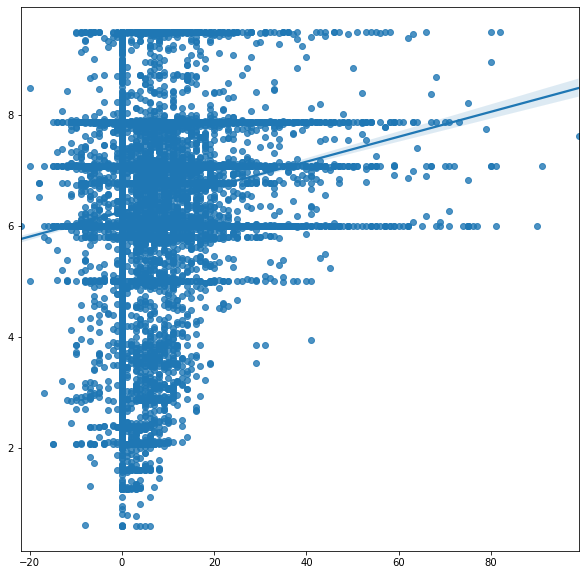

In [50]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

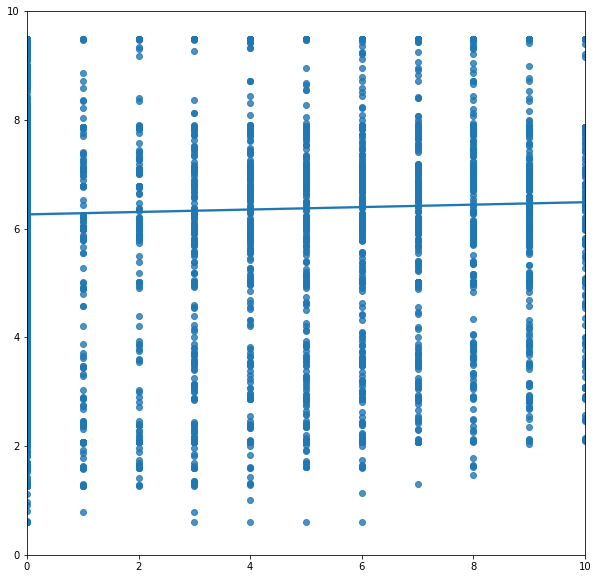

In [51]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

COMPLEX MODEL, RESIDUAL CONNECTION

In [52]:
inp = Input(shape=(X_train.shape[1],))

x = inp
# first pair
x = Dense(8, activation='sigmoid')(x)
x = Dense(4, activation='sigmoid')(x)
res1 = Dense(4, activation='sigmoid')(inp) # connection to the first pair
x = add([x,res1]) # add first residual with first pair

res2 = Dense(5, activation='sigmoid')(x) # connection to second paiR

# second pair
x = Dense(10, activation='sigmoid')(x)
x = Dense(5, activation='sigmoid')(x)
x = add([x,res2]) # add second residual with second pair

res3 = Dense(5, activation='sigmoid')(inp) # connection across the whole network, beginning to second residual connection
x = add([x, res3]) # add overaching residual with the output of the second pair/residual addition (x)

out = Dense(1, activation='linear')(x)

In [53]:
model = Model(inputs = inp, outputs=out)

es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.1))
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
841/841 [==============================] - 2s 2ms/step - loss: 101.2133 - val_loss: 102.0413
Epoch 2/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.9232 - val_loss: 102.2161
Epoch 3/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7882 - val_loss: 102.2052
Epoch 4/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7699 - val_loss: 102.3119
Epoch 5/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6907 - val_loss: 101.8549
Epoch 6/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6688 - val_loss: 102.8448
Epoch 7/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.7661 - val_loss: 102.1422
Epoch 8/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6711 - val_loss: 101.8941
Epoch 9/10000
841/841 [==============================] - 1s 1ms/step - loss: 100.6776 - val_loss: 102.5398
Epoch 10/10000
841/841 [=============

In [54]:
model.evaluate(X_test, Y_test)

586/586 [==============================] - 0s 818us/step - loss: 101.0802


101.08020782470703

<AxesSubplot:>

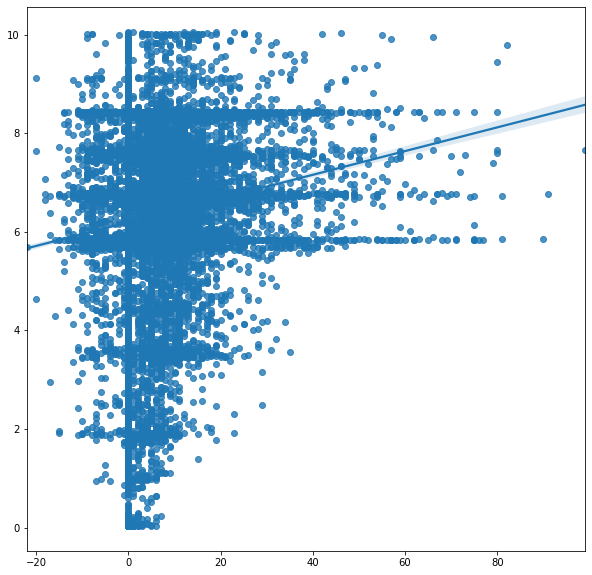

In [55]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

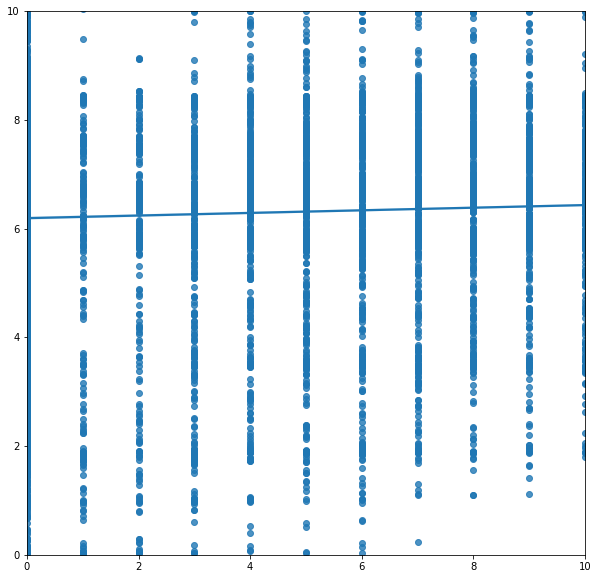

In [56]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

RUSH DATA

In [57]:
# feature, or input, dataframe
NFL_rush_x  = NFL_rush.drop(['yards_gained', 'play_type'], axis=1)
NFL_rush_x.head()

,game_seconds_remaining,yardline_100,ydstogo,posteam_score,defteam_score,AVG,YPG,down,shotgun,qb_kneel,qb_spike
176362,352.0,50.0,7,41.0,10.0,3.92,20.8,2.0,0,0,0
106976,2852.0,70.0,10,0.0,7.0,3.80,43.7,1.0,0,0,0
268634,2479.0,85.0,5,17.0,0.0,4.43,47.9,2.0,1,0,0
6567,505.0,73.0,10,20.0,19.0,4.44,61.6,1.0,0,0,0
183987,2802.0,80.0,10,10.0,10.0,3.92,20.8,1.0,1,0,0


In [58]:
NFL_rush_x = NFL_rush_x.values
NFL_rush_x

array([[3.520e+02, 5.000e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.852e+03, 7.000e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.479e+03, 8.500e+01, 5.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.103e+03, 4.400e+01, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.938e+03, 5.100e+01, 9.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.620e+02, 4.000e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [59]:
# label, or output, dataframe
NFL_rush_y = NFL_rush['yards_gained'].values
NFL_rush_y

array([-1.,  5.,  0., ...,  3.,  4., -1.])

In [60]:
#split the data
valid_split = 0.2
test_split = 0.1

In [61]:
# create the splits in the dataframe
v_split = int(NFL_rush.shape[0]*(1-valid_split-test_split))
t_split = int(NFL_rush.shape[0]*(1-test_split))

# assign training, validation, and test data
X_train, Y_train  = NFL_rush_x[:v_split], NFL_rush_y[:v_split]
X_valid, Y_valid  = NFL_rush_x[v_split:t_split], NFL_rush_y[v_split:t_split]
X_test , Y_test   = NFL_rush_x[t_split:], NFL_rush_y[t_split:]

In [62]:
#standardize the data
scaler = preprocessing.StandardScaler().fit(X_train[:,0:7]) # mean and variance calculated on specified columns of X_train
X_train[:,0:7] = scaler.transform(X_train[:,0:7])
X_valid[:,0:7] = scaler.transform(X_valid[:,0:7])
X_test[:,0:7]  = scaler.transform(X_test[:,0:7])  

BASIC MODEL, RUSHING

In [63]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                input_shape=(NFL_rush_x.shape[1],), 
                activation='tanh'))
model.add(Dense(1, 
                activation='linear'))

In [64]:
model.compile(loss='mean_squared_error', 
              optimizer=Adam(learning_rate=0.1))

In [65]:
es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

In [66]:
model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.7412 - val_loss: 39.1998
Epoch 2/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.5965 - val_loss: 39.0659
Epoch 3/1000
603/603 [==============================] - 1s 982us/step - loss: 41.5769 - val_loss: 38.8734
Epoch 4/1000
603/603 [==============================] - 1s 992us/step - loss: 41.5581 - val_loss: 39.0027
Epoch 5/1000
603/603 [==============================] - 1s 993us/step - loss: 41.5416 - val_loss: 38.8485
Epoch 6/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.5420 - val_loss: 38.7875
Epoch 7/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.5012 - val_loss: 38.9136
Epoch 8/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.6005 - val_loss: 38.7664
Epoch 9/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.4752 - val_loss: 39.4446
Epoch 10/1000
603/603 [==============================] - 1

In [67]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 707us/step - loss: 42.3242


42.32422637939453

<AxesSubplot:>

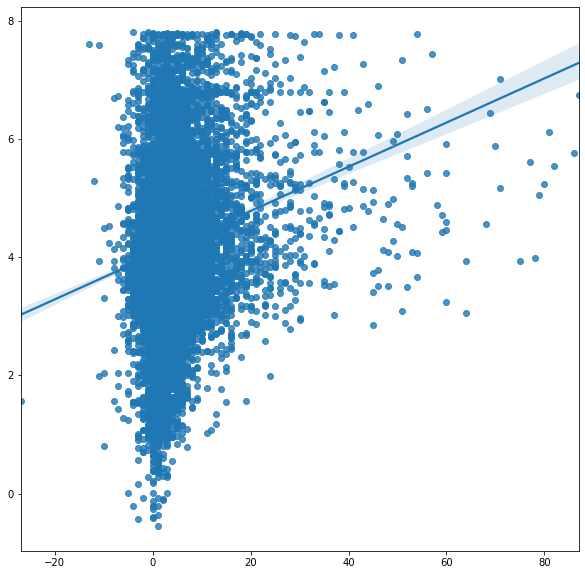

In [68]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

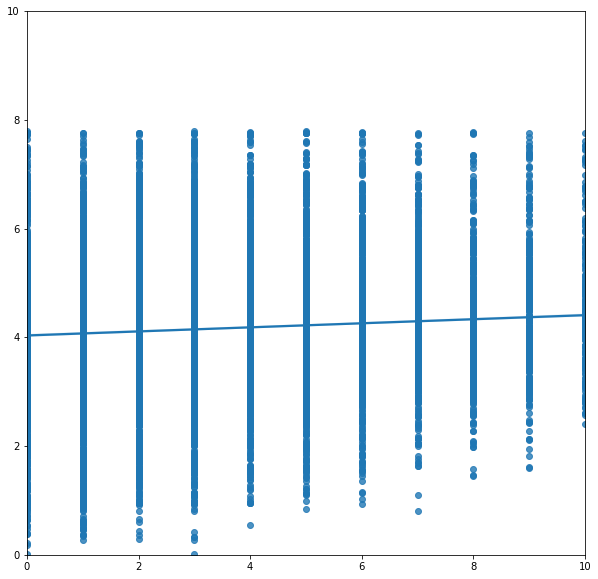

In [69]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

COMPLEX FULLY CONNECTED, RUSHING

In [70]:
# initiate model
model = Sequential()

# add layers
model.add(Dense(20, 
                activation='tanh'))
model.add(Dense(20, 
                activation='tanh'))
model.add(Dense(20,  
                activation='tanh'))
model.add(Dense(1, 
                activation='linear'))


model.compile(loss='mean_squared_error', 
              optimizer=Adam(learning_rate=0.1))

es = EarlyStopping(monitor='val_loss', 
                   patience=10, 
                   verbose=1,
                   restore_best_weights=True)

model.fit(X_train, Y_train, 
          epochs=1000, 
          callbacks=[es],
          batch_size=156, 
          shuffle=True,  
          validation_data=(X_valid, Y_valid))

Epoch 1/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.3559 - val_loss: 40.0675
Epoch 2/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.1694 - val_loss: 40.1770
Epoch 3/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.1168 - val_loss: 39.9535
Epoch 4/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.1136 - val_loss: 39.4354
Epoch 5/1000
603/603 [==============================] - 1s 1ms/step - loss: 41.9986 - val_loss: 39.4008
Epoch 6/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.0497 - val_loss: 39.3343
Epoch 7/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.0985 - val_loss: 39.8271
Epoch 8/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.1134 - val_loss: 39.2723
Epoch 9/1000
603/603 [==============================] - 1s 1ms/step - loss: 42.0368 - val_loss: 39.7106
Epoch 10/1000
603/603 [==============================] - 1s 1ms/

In [71]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 705us/step - loss: 42.6991


42.6991081237793

<AxesSubplot:>

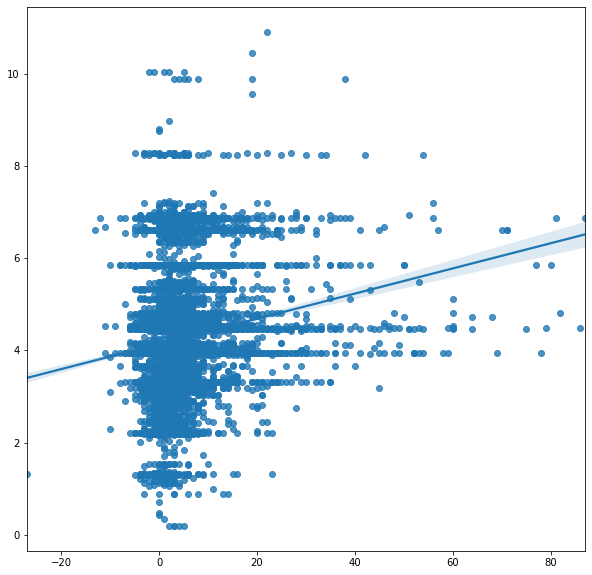

In [72]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

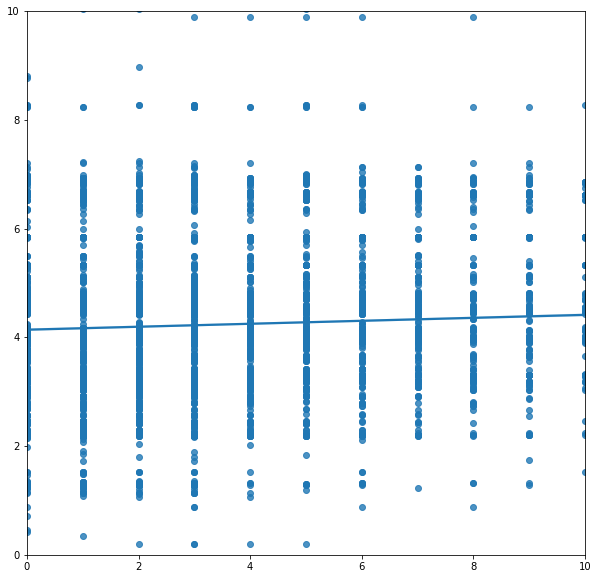

In [73]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

BASIC MODEL, RESIDUAL CONNECTIONS

In [74]:
# Model
inp = Input(shape=(X_train.shape[1],))

x = inp
x = Dense(10, activation='sigmoid')(x)
x = Dense(5, activation='sigmoid')(x)

res = Dense(5, activation='sigmoid')(inp)

x = add([x,res])

out = Dense(1, activation='linear')(x)

In [75]:
model = Model(inputs = inp, outputs=out)

In [76]:
es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.1))
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          epochs=10000, 
          batch_size=156,
          callbacks=[es])

Epoch 1/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.6982 - val_loss: 38.9081
Epoch 2/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.2805 - val_loss: 38.8586
Epoch 3/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1977 - val_loss: 38.7420
Epoch 4/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1314 - val_loss: 38.6597
Epoch 5/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1391 - val_loss: 38.6712
Epoch 6/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1525 - val_loss: 38.6666
Epoch 7/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1755 - val_loss: 38.7324
Epoch 8/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1295 - val_loss: 38.6142
Epoch 9/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1064 - val_loss: 38.7448
Epoch 10/10000
603/603 [==============================]

In [77]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 724us/step - loss: 42.1462


42.14617156982422

<AxesSubplot:>

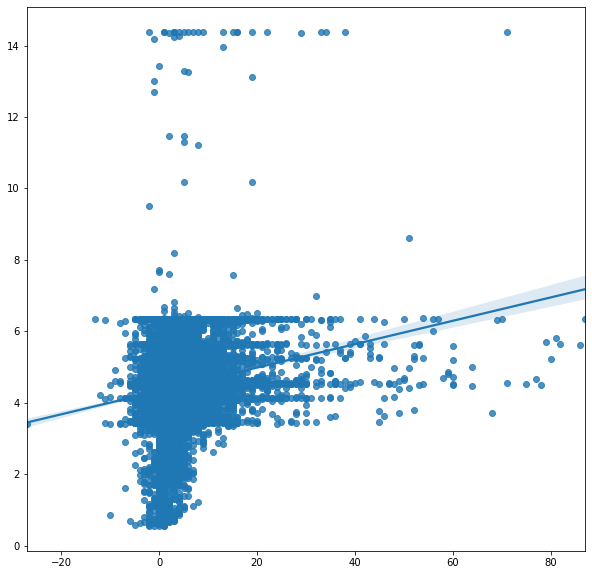

In [78]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

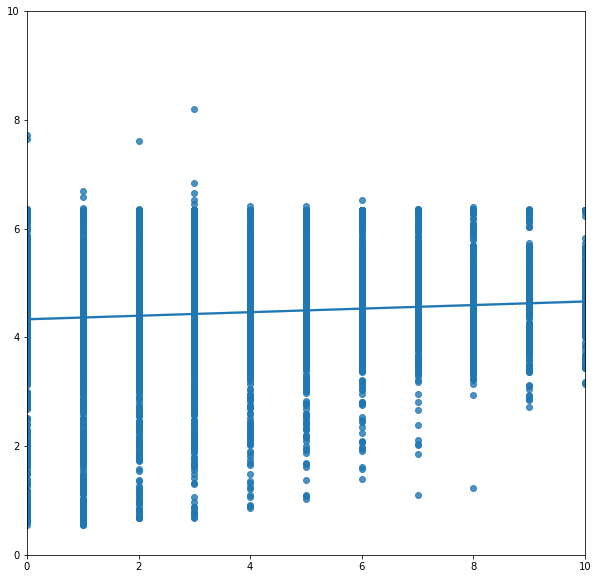

In [79]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

COMPLEX MODEL, RESIDUAL CONNECTIONS

In [80]:
inp = Input(shape=(X_train.shape[1],))

x = inp
# first pair
x = Dense(8, activation='sigmoid')(x)
x = Dense(4, activation='sigmoid')(x)
res1 = Dense(4, activation='sigmoid')(inp) # connection to the first pair
x = add([x,res1]) # add first residual with first pair

res2 = Dense(5, activation='sigmoid')(x) # connection to second paiR

# second pair
x = Dense(10, activation='sigmoid')(x)
x = Dense(5, activation='sigmoid')(x)
x = add([x,res2]) # add second residual with second pair

res3 = Dense(5, activation='sigmoid')(inp) # connection across the whole network, beginning to second residual connection
x = add([x, res3]) # add overaching residual with the output of the second pair/residual addition (x)

out = Dense(1, activation='linear')(x)


model = Model(inputs = inp, outputs=out)

es = EarlyStopping(patience=10, 
                   monitor='val_loss', 
                   restore_best_weights=True)
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.1))
model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          batch_size=156,
          epochs=10000, 
          callbacks=[es])

Epoch 1/10000
603/603 [==============================] - 1s 2ms/step - loss: 41.4676 - val_loss: 39.3434
Epoch 2/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.3151 - val_loss: 38.7180
Epoch 3/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.2035 - val_loss: 38.6453
Epoch 4/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1449 - val_loss: 38.6386
Epoch 5/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1419 - val_loss: 38.7185
Epoch 6/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1921 - val_loss: 38.9129
Epoch 7/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1970 - val_loss: 38.6573
Epoch 8/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1545 - val_loss: 38.7142
Epoch 9/10000
603/603 [==============================] - 1s 1ms/step - loss: 41.1500 - val_loss: 38.6284
Epoch 10/10000
603/603 [==============================]

In [81]:
model.evaluate(X_test, Y_test)

420/420 [==============================] - 0s 821us/step - loss: 42.0867


42.08668899536133

<AxesSubplot:>

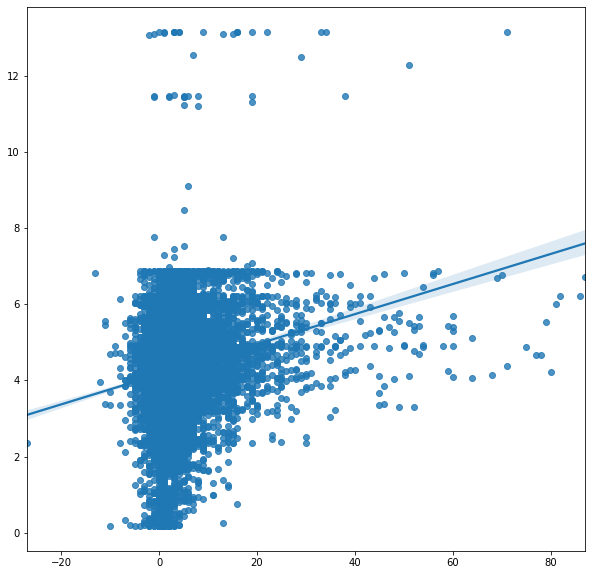

In [82]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1))

[(0.0, 10.0), (0.0, 10.0)]

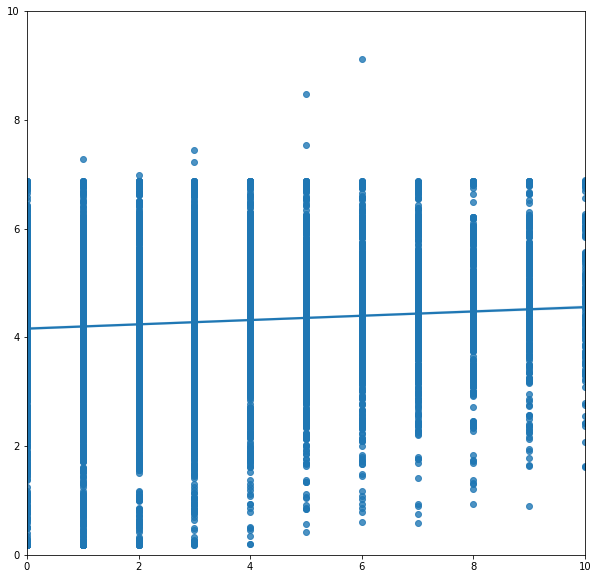

In [83]:
preds = model.predict(X_test)

plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.reshape(-1), y=preds.reshape(-1)).set(xlim=(0,10),ylim=(0,10))

GUESSING THE AVERAGE (PASSING)

In [84]:
target_variance = NFL_pass_y.var()
print("Target Variance:", target_variance)

target_sd = math.sqrt(target_variance)
print("Target Standard Deviation:", target_sd)

Target Variance: 103.07044269623451
Target Standard Deviation: 10.152361434475948


GUESSING THE AVERAGE (RUSHING)

In [85]:
target_variance = NFL_rush_y.var()
print("Target Variance:", target_variance)

target_sd = math.sqrt(target_variance)
print("Target Standard Deviation:", target_sd)

Target Variance: 42.259607361491504
Target Standard Deviation: 6.500738985799345


LINEAR REGRESSION BASELINE (PASSING)

In [86]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split

In [87]:
pass_attrs = NFL_pass_x
pass_labels = NFL_pass_y

In [88]:
pass_features_train, pass_features_test, pass_labels_train, pass_labels_test = train_test_split(pass_attrs, pass_labels, test_size=0.33, random_state=22)

In [89]:
lm = LinearRegression()
lm.fit(pass_features_train, pass_labels_train)
pred_test = lm.predict(pass_features_test)

In [90]:
lm_mse = np.mean((pass_labels_test - pred_test)**2)
print("MSE:", lm_mse)

lm_rmse = math.sqrt(lm_mse)
print("RMSE:", lm_rmse)

MSE: 100.37015395545318
RMSE: 10.018490602653335


LINEAR REGRESSION BASELINE (RUSHING)

In [91]:
rush_attrs = NFL_rush_x
rush_labels = NFL_rush_y

In [92]:
rush_features_train, rush_features_test, rush_labels_train, rush_labels_test = train_test_split(rush_attrs, rush_labels, test_size=0.33, random_state=22)

In [93]:
lm = LinearRegression()
lm.fit(rush_features_train, rush_labels_train)
pred_test = lm.predict(rush_features_test)

In [94]:
lm_mse = np.mean((rush_labels_test - pred_test)**2)
print("MSE:", lm_mse)

lm_rmse = math.sqrt(lm_mse)
print("RMSE:", lm_rmse)

MSE: 41.43201210211828
RMSE: 6.436770316091625
